El artículo de Seager & Mallén-Ornelas ([2003](http://iopscience.iop.org/article/10.1086/346105/pdf)) describe 4 parámetro que se pueden extraer de las curvas de luz:

* $\Delta F$: la profundidad del tránsito, que corresponde a la diferencie entre el flujo fuera del tránsito, y el flujo del tránsito, normalizado por el flujo fuera del tránsito.
* $t_T$: la duración total del tránsito
* $t_F$: la duración del tránsito, con el planeta completamente adentro.
* $P$: el período.

A partir de ellos podemos extraer:

* $a$: Eje mayor en radios estelares.
* $\rho_*$: Densidad de la estrella.
* $R_p$: Radio del planeta en radios estelares.
* $i$: La inclinación orbital.

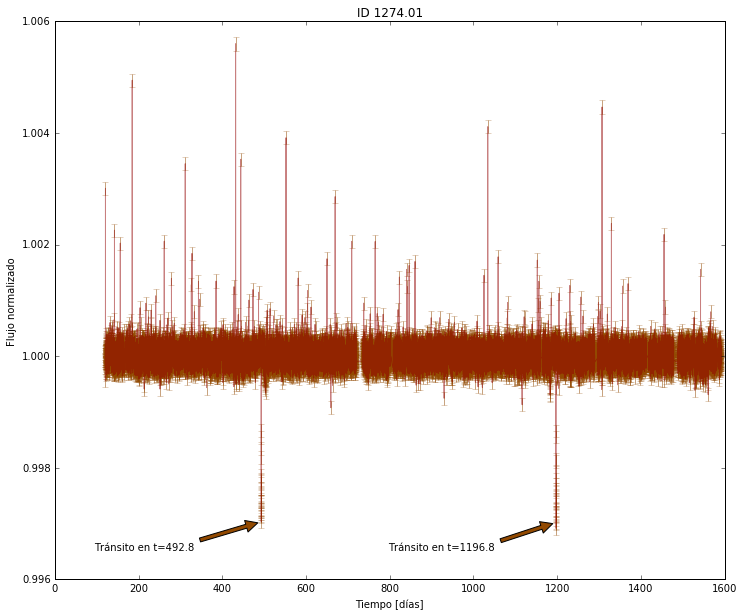

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import kplr
import operator

# Configuración de los gráficos.
%matplotlib inline
main_color = '#920000'
err_color = '#924900'
other_color = '#49008F'

# Para extraer los datos.
client = kplr.API()

# Lista de KOIs
kois = [1274.01]
# Diccionario de KOIs
dict_koi = dict((key, dict()) for key in kois)

# Download the lightcurves for this KOI.
for koi in kois:
    star = client.koi(koi)
    #params = (star.kepid, star.koi_teff, star.koi_logg, star.koi_feh, star.koi_radius)
    #print(64 * "#")
    #print(64 * "#" + "\n")
    #text = "ID = {}\nTeff = {}\nLog G  = {}\nMetalicidad = {}\nRadio = {}\n".format(*params)
    #print(text)
    lcs = star.get_light_curves()
    time, flux, ferr, quality = [], [], [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            time.append(hdu_data["time"])
            flux.append(hdu_data["pdcsap_flux"])
            ferr.append(hdu_data["pdcsap_flux_err"])
    # Guardamos los datos en el diccionario
    dict_koi[koi]['Time'] = time
    dict_koi[koi]['Flux'] = flux
    dict_koi[koi]['Ferr'] = ferr
#print(64 * "#")
#print(64 * "#")

plt.show()

# Unir trozos
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=.5)
axs = {1274.01: ax1}

for koi in dict_koi.keys():
    for ind, quarter_flux in enumerate(dict_koi[koi]['Flux']):
        median = np.nanmedian(quarter_flux)
        dict_koi[koi]['Flux'][ind] /= median
        # Un servidor no conoce una manera mejor de encontrar el valor absluto mayor.
        #maximo = abs(np.nanmax(dict_koi[koi]['Flux'][ind]))
        #minimo = abs(np.nanmin(dict_koi[koi]['Flux'][ind]))
        #maximo = maximo if maximo > minimo else minimo
        dict_koi[koi]['Ferr'][ind] /= median
        
        # Por algún motivo gatspy no está ni ahí con los nan, así que hay que quitarlos.
        delnan = np.isnan(dict_koi[koi]['Flux'][ind])
        dict_koi[koi]['Flux'][ind] = dict_koi[koi]['Flux'][ind][~delnan]
        dict_koi[koi]['Time'][ind] = dict_koi[koi]['Time'][ind][~delnan]
        dict_koi[koi]['Ferr'][ind] = dict_koi[koi]['Ferr'][ind][~delnan]
        
    time = dict_koi[koi]['Time']
    flux = dict_koi[koi]['Flux']
    ferr = dict_koi[koi]['Ferr']
    
    time = np.concatenate(tuple(dict_koi[koi]['Time']))
    flux = np.concatenate(tuple(dict_koi[koi]['Flux']))
    ferr = np.concatenate(tuple(dict_koi[koi]['Ferr']))
    
    dict_koi[koi]['Time'] = time
    dict_koi[koi]['Flux'] = flux
    dict_koi[koi]['Ferr'] = ferr
    
    # Obtener los tránsitos
    m = np.ma.masked_where(flux < 0.99712, flux)  # Valor 0.99712 sacado mirando el gráfico.
    trans = list(zip(time[m.mask][0: 2], flux[m.mask][0: 2]))
    #for ind in range(0, len(dict_koi[koi]['Flux'])):
    axs[koi].errorbar(time, flux, ferr, fmt='-',
                      color=main_color, label="data", ecolor=err_color,
                      alpha=0.5)
    for x in trans:
        b = (-400, -0.0005)
        pos_tayer = tuple(map(operator.add, x, b))
        text = "Tránsito en t={0:.1f}".format(x[0])
        axs[koi].annotate(text, xy=x, xytext=pos_tayer,
                arrowprops=dict(facecolor=err_color, shrink=0.05),
                )
    axs[koi].set_xlabel('Tiempo [días]')
    axs[koi].set_ylabel('Flujo normalizado')
    axs[koi].set_title('ID {}'.format(koi))
plt.show()

Aplicamos un _median filter_ para limpiar de errores sistemáticos:

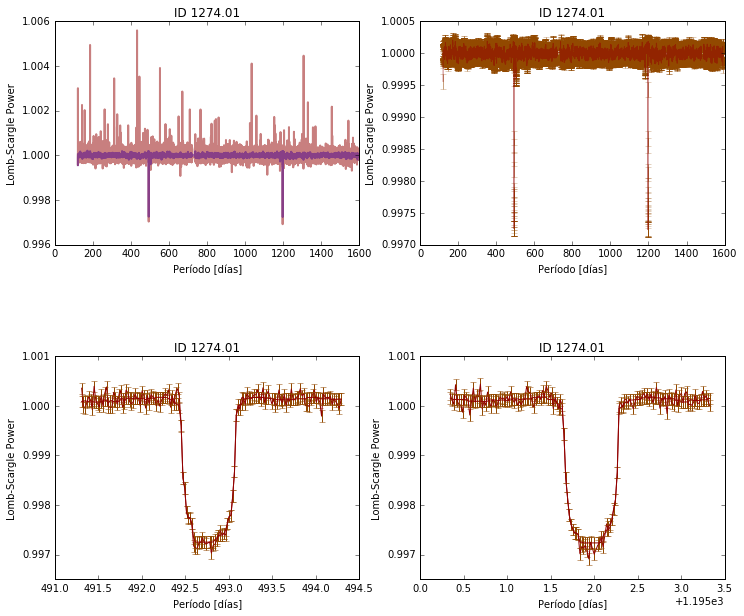

In [2]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=.5)
axs = {1274.01: {0: ax1, 1: ax2, 2: ax3, 3: ax4}}

for koi in dict_koi.keys():
    ind = 0
    time = dict_koi[koi]['Time']
    flux = dict_koi[koi]['Flux']
    ferr = dict_koi[koi]['Ferr']
    
    f_flux = signal.medfilt(flux, 19)
    dict_koi[koi]['FFlux'] = f_flux

    # Plot the results
    axs[koi][ind].plot(time, flux, color=main_color, linewidth=2, alpha=0.5)
    axs[koi][ind].plot(time, f_flux, color=other_color, linewidth=2, alpha=0.5)
    axs[koi][ind].set_xlabel('Período [días]')
    axs[koi][ind].set_ylabel('Lomb-Scargle Power')
    axs[koi][ind].set_title('ID {}'.format(koi))
    ind += 1
    
    # Plot the results
    axs[koi][ind].errorbar(time, f_flux, ferr, fmt='-',
                          color=main_color, label="data", ecolor=err_color,
                          alpha=0.5)
    axs[koi][ind].set_xlabel('Período [días]')
    axs[koi][ind].set_ylabel('Lomb-Scargle Power')
    axs[koi][ind].set_title('ID {}'.format(koi))
    ind += 1
    for x in trans:
        m = np.ma.masked_inside(time, x[0]-1.5, x[0]+1.5)
        time_orb = time[m.mask] 
        flux_orb = flux[m.mask]
        f_flux_orb = f_flux[m.mask]
        ferr_orb = ferr[m.mask]
        axs[koi][ind].errorbar(time_orb , flux_orb, ferr_orb, fmt='-',
                          color=main_color, label="data", ecolor=err_color)
        axs[koi][ind].errorbar(time_orb, f_flux_orb, ferr_orb, fmt='-',
                          color=main_color, label="data", ecolor=err_color)
        axs[koi][ind].set_xlabel('Período [días]')
        axs[koi][ind].set_ylabel('Lomb-Scargle Power')
        axs[koi][ind].set_title('ID {}'.format(koi))
        ind += 1
    
    
plt.show()


Ahora faseamos lo anterior:

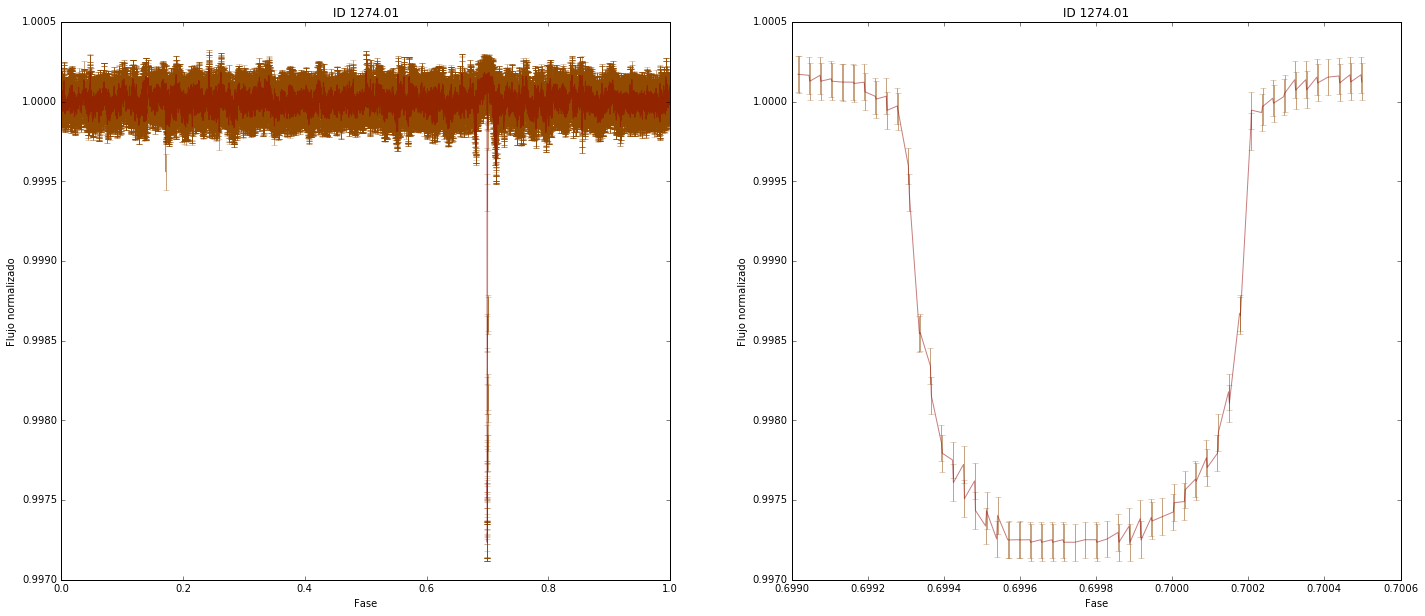

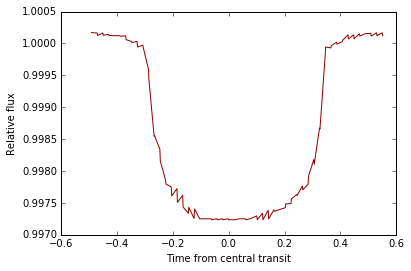

In [3]:
# Fasear
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.subplots_adjust(hspace=.5)
axs = {1274.01: {0:ax1, 1: ax2}}

for koi in dict_koi.keys():
    ind = 0
    time = dict_koi[koi]['Time']
    flux = dict_koi[koi]['FFlux']
    ferr = dict_koi[koi]['Ferr']
    
    dict_koi[koi]['Period'] = 704.2
    period = dict_koi[koi]['Period']

    # Plot the results
    phase = (time / period) % 1
    
    #Unimos el flujo
    flux_x2 = list(zip(flux, ferr))
    datos = list(zip(phase, flux_x2))
    datos.sort()
    
    phase, flux_2 = zip(*datos)
    flux, ferr = zip(*flux_2)
    phase = np.array(phase)
    flux = np.array(flux)
    ferr = np.array(ferr)
    
    axs[koi][ind].errorbar(phase, flux, yerr=ferr, fmt='-',
                      color=main_color, ecolor=err_color,
                      alpha=0.5)
    axs[koi][ind].set_xlabel('Fase')
    axs[koi][ind].set_ylabel('Flujo normalizado')
    axs[koi][ind].set_title('ID {}'.format(koi))
    
    ind += 1
    m = np.ma.masked_inside(phase, 0.699, 0.7005)
    
    phase = phase[m.mask]
    flux = flux[m.mask]
    ferr = ferr[m.mask]
    
    axs[koi][ind].errorbar(phase, flux, yerr=ferr, fmt='-',
                      color=main_color, ecolor=err_color,
                      alpha=0.5)
    axs[koi][ind].set_xlabel('Fase')
    axs[koi][ind].set_ylabel('Flujo normalizado')
    axs[koi][ind].set_title('ID {}'.format(koi))
plt.show()

plt.plot(phase * 704.2 - np.median(phase) * 704.2, flux, color=main_color)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()


Al ojo vemos los siguientes parámetros:

* $\Delta F$: 0.0027
* $t_T$: 0.704
* $t_F$: 0.281
* $P$: 704.2

Utilizando estos parámetros y la ecuacioens de Seager & Mallén-Ornelas, obtenemos lo siguiente:

In [4]:
import trans_parameters as tp  # Ecuaciones de Seager & Mallén-Ornelas
from astropy.io import ascii
from astropy.table import Table

inten = ascii.read("grav_4.5_lh_1.25.dat")
names = ['wav', '1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4',
          '0.3', '0.25', '0.2', '0.15', '0.125', '0.1' ,
          '0.075', '0.05', '0.025', '0.01']
for ind in range(0, 18):
    inten.rename_column('col{}'.format(ind+1), names[ind])

resp = ascii.read("kepler_response_hires1.txt")
names = ['wav', 'trans']
for ind in range(0, 2):
    resp.rename_column('col{}'.format(ind+1), names[ind])

trans_param = tp.TransParameters(704.2, 0.0027, 0.704, 0.281)
radius_p = trans_param.radius_planet
density_s = trans_param.density_star
inclination = trans_param.inclination

text = "Radio del planeta = {:.3f}\n".format(radius_p)
text += "Densidad de la estrella = {:.3f}\nInclinación = {:.3f}\n".format(density_s, inclination)
text += "a = {:.3f}\nb = {:.3f}".format(trans_param.a_r, trans_param.b)
print(text)

Radio del planeta = 0.052
Densidad de la estrella = 0.107
Inclinación = 1.565
a = 158.317
b = 0.927


Ahora calculamos los coeficientes de _limb-darkening_ para un modelo cuadrático:

In [5]:
from scipy.optimize import least_squares

def quadratic_law(u1, u2, mu):
    mu = np.array(mu, dtype='|S4')
    mu = mu.astype(np.float)
    rest = (1 - mu)
    return 1 - u1 * rest - u2 * np.power(rest, 2)

def real_value(x, mu):
    if mu == '1.0':
        return x[mu]
    else:
        return x['1.0'] * x[mu] / np.power(10., 5)
    

def trans(resp, wav):
    dif = np.abs(np.array(resp['wav']) - wav) # Busca la diferencia con todos.
    mini = np.min(dif)  # Si el mínimo es pequeño, lo entrega.
    if mini < 1:
        mask = np.ma.masked_equal(dif, np.min(dif))
        return resp[mask.mask]['trans'][0]
    else:
        return 0
    
def integrate(inten, resp, mu):
    waves = np.array(resp['wav'])
    mini = np.min(waves)
    maxi = np.max(waves)
    n_sum = 0
    res = 0  # Respuesta
    for x in inten:
        if x['wav'] > mini and x['wav'] < maxi:
            res += real_value(x, mu) * trans(resp, x['wav']) / x['wav']
            n_sum += 1
        elif res > 0:
            return res * (maxi - mini) / n_sum    

def fun_quad(coef, inten, resp, mu):
    quad = quadratic_law(*coef, mu)
    
    i_1 = integrate(inten, resp, '1.0')
    inte = integrate(inten, resp, mu) / i_1
    
    return quad - inte

def err(coef, inten, resp, mu):
    error = list()
    for x in mu:
        error.append(fun_quad(coef, inten, resp, x))
    return np.array(error)

x0 = [0, 0]
args = (inten, resp, ['0.9', '0.8', '0.7', '0.6', '0.5', '0.4',
          '0.3', '0.25', '0.2', '0.15', '0.125', '0.1' ,
          '0.075', '0.05', '0.025', '0.01'])
res_lsq = least_squares(err, x0, args=args,
                        verbose=0)
coef = res_lsq.x
print("Los coeficientes corresponden a:\nc1 = {:.3f}\nc2 = {:.3f}".format(*coef))

Los coeficientes corresponden a:
c1 = 0.465
c2 = 0.238


Período = 704.200
Radio del planeta = 0.020
Semi-eje mayor = 189.946
Inclinación = 330.341
Periastron = 160.000


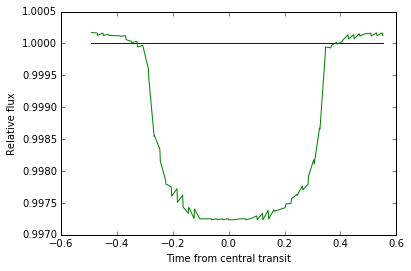

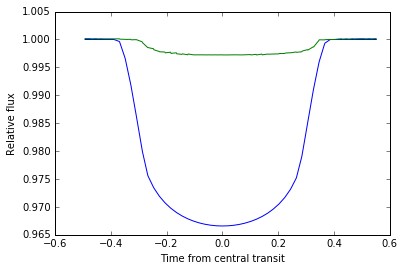

In [6]:
import batman

def fun_batman(arg, coef, phase):
    params = batman.TransitParams()
    params.t0 = arg[0]                  #  time of inferior conjunction
    params.per = 704.2                  #  orbital period
    params.rp = arg[1]                   #  planet radius (in units of stellar radii)
    params.a = arg[2]                    #  semi-major axis (in units of stellar radii)
    params.inc = arg[3]                  #  orbital inclination (in degrees)
    params.ecc = 0                       #  eccentricity
    params.w = arg[4]                    #  longitude of periastron (in degrees)
    params.u = coef                      #  limb darkening coefficients
    params.limb_dark = "quadratic"       #  limb darkening model

    t = phase * 704.2 - np.median(phase) * 704.2
    m = batman.TransitModel(params, t)    #  initializes model
    flux = m.light_curve(params)          #  calculates light curve
    return flux

def err_batman(arg, coef, flux, phase):
    error = fun_batman(arg, coef, phase) - flux
    return error

x0 = [0.0008, np.sqrt(0.027), 158.317, 90, 160]
res_lsq = least_squares(err_batman, x0, args=(coef, flux, phase), 
                        verbose=0)
arg = res_lsq.x

params = batman.TransitParams()
params.t0 = arg[0]                    #  time of inferior conjunction
params.per = 704.2                  #  orbital period
params.rp = arg[1]                   #  planet radius (in units of stellar radii)
params.a = arg[2]                    #  semi-major axis (in units of stellar radii)
params.inc = arg[3]                  #  orbital inclination (in degrees)
params.ecc = 0                       #  eccentricity
params.w = arg[4]                    #  longitude of periastron (in degrees)
params.u = coef                      #  limb darkening coefficients
params.limb_dark = "quadratic"       #  limb darkening model

text = "Período = {:.3f}\nRadio del planeta = {:.3f}\n".format(704.2, arg[0])
text += "Semi-eje mayor = {:.3f}\nInclinación = {:.3f}\n".format(arg[2], arg[3])
text += "Periastron = {:.3f}".format(arg[4])
print(text)

t = phase * 704.2 - np.median(phase) * 704.2
m = batman.TransitModel(params, t)    #  initializes model
flux_bat = m.light_curve(params)          #  calculates light curve

plt.plot(t, flux_bat)
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

params = batman.TransitParams()
params.t0 = x0[0]                      #time of inferior conjunction
params.per = 704.2                      #orbital period
params.rp = x0[1]                       #planet radius (in units of stellar radii)
params.a = 346                      #semi-major axis (in units of stellar radii)
params.inc = x0[3]                      #orbital inclination (in degrees)
params.ecc = 0                     #eccentricity
params.w = x0[4]                       #longitude of periastron (in degrees)
params.u = coef                #limb darkening coefficients
params.limb_dark = "quadratic"       #limb darkening model

t =phase * 704.2 - np.median(phase) * 704.2
m = batman.TransitModel(params, t)    #initializes model
fluxt = m.light_curve(params)          #calculates light curve
plt.plot(t, fluxt)
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()
